# Covid-19 Fake News Detection
 

*   [Google Doc informatii generale](https://docs.google.com/document/d/1oVGBUXDLXlRHuM5gUXCFhZfhvTO1tIGL7-8b0IRrM7U/edit)



## Conectare Google Drive
Pentru a putea accesa dataset-ul folosind Drive, acesta va trebui descarcat si pus in locatia: `MyDrive/Colab Notebooks/Covid-19 Fake News Detection/dataset`

Exista si varianta de `wget` la inceputul notebook-ului, pentru a evita folosirea Google Drive (?)

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Imports

In [2]:
import os # OS path
import numpy as np # NumPy
import pandas as pd # Files read
import re # Regex for strings

## Citire date

In [3]:
dataset_path = "/content/gdrive/MyDrive/Colab Notebooks/Covid-19 Fake News Detection/dataset/"

train_path = os.path.join(dataset_path, "covid_train.csv")
val_path = os.path.join(dataset_path, "covid_val.csv")

def citire_date(path, rows) -> pd.DataFrame:
  return pd.read_csv(path, delimiter = ',', nrows = rows)

train_dataset = citire_date(train_path, 6420)
val_dataset = citire_date(val_path, 2140)

print("*** Train ***")
print(train_dataset.head(10))
print(train_dataset.shape)
print("\n")

print("*** Validation ***")
print(val_dataset.head(10))
print(val_dataset.shape)

*** Train ***
   id                                              tweet label
0   1  The CDC currently reports 99031 deaths. In gen...  real
1   2  States reported 1121 deaths a small rise from ...  real
2   3  Politically Correct Woman (Almost) Uses Pandem...  fake
3   4  #IndiaFightsCorona: We have 1524 #COVID testin...  real
4   5  Populous states can generate large case counts...  real
5   6  Covid Act Now found "on average each person in...  real
6   7  If you tested positive for #COVID19 and have n...  real
7   8  Obama Calls Trump’s Coronavirus Response A Cha...  fake
8   9  ???Clearly, the Obama administration did not l...  fake
9  10  Retraction—Hydroxychloroquine or chloroquine w...  fake
(6420, 3)


*** Validation ***
   id                                              tweet label
0   1  Chinese converting to Islam after realising th...  fake
1   2  11 out of 13 people (from the Diamond Princess...  fake
2   3  COVID-19 Is Caused By A Bacterium, Not Virus A...  fake
3   4  Mik

## Statistici

In [4]:
def get_words_count(tweet):
  return len(re.split(' |,', tweet))

def get_chars_count(tweet):
  return len(tweet)

def get_urls_count(tweet):
  return len(re.findall(r'(?:https?:\/\/www|https?:\/\/|s?ftp:\/\/|www)', tweet))

def get_hashtag_cout(tweet):
  return len(re.findall('#',tweet))

dataset = train_dataset.append(val_dataset)
dataset_real = dataset[dataset['label'] == 'real']
dataset_fake = dataset[dataset['label'] == 'fake']

words_avg_real = np.vectorize(get_words_count)(dataset_real['tweet']).mean()
words_avg_fake = np.vectorize(get_words_count)(dataset_fake['tweet']).mean()
print("Average words per real tweet: ", words_avg_real)
print("Average words per fake tweet: ", words_avg_fake, '\n')

chars_avg_real = np.vectorize(get_chars_count)(dataset_real['tweet']).mean()
chars_avg_fake = np.vectorize(get_chars_count)(dataset_fake['tweet']).mean()
print("Average chars per real tweet: ", chars_avg_real)
print("Average chars per fake tweet: ", chars_avg_fake, '\n')

urls_avg_real = np.vectorize(get_urls_count)(dataset_real['tweet']).mean()
urls_avg_fake = np.vectorize(get_urls_count)(dataset_fake['tweet']).mean()
print("Average URLs per real tweet: ", urls_avg_real)
print("Average URLs per fake tweet: ", urls_avg_fake, '\n')

hashtag_avg_real = np.vectorize(get_hashtag_cout)(dataset_real['tweet']).mean()
hashtag_avg_fake = np.vectorize(get_hashtag_cout)(dataset_fake['tweet']).mean()
print("Average hashtags per real tweet: ", hashtag_avg_real)
print("Average hashtags per fake tweet: ", hashtag_avg_fake, '\n')

max_words_real = np.vectorize(get_words_count)(dataset_real['tweet']).max()
max_words_fake = np.vectorize(get_words_count)(dataset_fake['tweet']).max()
print("Maximum no. of words in a real tweet: ", max_words_real)
print("Maximum no. of words in a fake tweet: ", max_words_fake, '\n')

min_words_real = np.vectorize(get_words_count)(dataset_real['tweet']).min()
min_words_fake = np.vectorize(get_words_count)(dataset_fake['tweet']).min()
print("Minimum no. of words in a real tweet: ", min_words_real)
print("Minimum no. of words in a fake tweet: ", min_words_fake, '\n')

Average words per real tweet:  31.745982142857144
Average words per fake tweet:  21.87794117647059 

Average chars per real tweet:  215.37433035714287
Average chars per fake tweet:  143.51519607843136 

Average URLs per real tweet:  0.9419642857142857
Average URLs per fake tweet:  0.40980392156862744 

Average hashtags per real tweet:  1.0600446428571428
Average hashtags per fake tweet:  0.49950980392156863 

Maximum no. of words in a real tweet:  297
Maximum no. of words in a fake tweet:  1409 

Minimum no. of words in a real tweet:  3
Minimum no. of words in a fake tweet:  3 



In [5]:
#number of unique words
import torch


def decontracted(phrase):
  #eliminate links
  phrase = re.sub(r"\S*https?:\S*", "", phrase) 
  
  # specific
  phrase = re.sub(r"won\'t", "will not", phrase)
  phrase = re.sub(r"can\'t", "can not", phrase)

  # general
  phrase = re.sub(r"n\'t", " not", phrase)
  phrase = re.sub(r"\'re", " are", phrase)
  phrase = re.sub(r"\'s", " is", phrase)
  phrase = re.sub(r"\'d", " would", phrase)
  phrase = re.sub(r"\'ll", " will", phrase)
  phrase = re.sub(r"\'t", " not", phrase)
  phrase = re.sub(r"\'ve", " have", phrase)
  phrase = re.sub(r"\'m", " am", phrase)
  return phrase
  
new_dataset = []
for data in dataset['tweet']:
  element = decontracted(data)
  new_dataset.append(element)

def replace_punctuation(tweet):
  tweet = re.sub('[^A-Za-z0-9]+', ' ', tweet.lower())
  return tweet

def split_tweet(tweet):
  tokens = tweet.split(" ")
  token_list = [x for x in tokens if x != '' and x!='https' and x!='http' and x!='s']
  return token_list

list_of_words = []
for data in new_dataset:
  element = split_tweet(replace_punctuation(data))
  list_of_words.extend(element)  
print(list_of_words)

list_of_unique_words = list(set(list_of_words))

print("Number of unique words: " + str(len(list_of_unique_words)))


['the', 'cdc', 'currently', 'reports', '99031', 'deaths', 'in', 'general', 'the', 'discrepancies', 'in', 'death', 'counts', 'between', 'different', 'sources', 'are', 'small', 'and', 'explicable', 'the', 'death', 'toll', 'stands', 'at', 'roughly', '100000', 'people', 'today', 'states', 'reported', '1121', 'deaths', 'a', 'small', 'rise', 'from', 'last', 'tuesday', 'southern', 'states', 'reported', '640', 'of', 'those', 'deaths', 'politically', 'correct', 'woman', 'almost', 'uses', 'pandemic', 'as', 'excuse', 'not', 'to', 'reuse', 'plastic', 'bag', 'coronavirus', 'nashville', 'indiafightscorona', 'we', 'have', '1524', 'covid', 'testing', 'laboratories', 'in', 'india', 'and', 'as', 'on', '25th', 'august', '2020', '36827520', 'tests', 'have', 'been', 'done', 'profbhargava', 'dg', 'icmrdelhi', 'staysafe', 'indiawillwin', 'populous', 'states', 'can', 'generate', 'large', 'case', 'counts', 'but', 'if', 'you', 'look', 'at', 'the', 'new', 'cases', 'per', 'million', 'today', '9', 'smaller', 'stat

## Pre-procesarea datelor

In [6]:
# import nltk
# nltk.download('stopwords')

# from nltk.corpus import stopwords

# stop_words = set(stopwords.words('english'))
# stop_words.add('is')

# Splitting data
train_data = []
for data in train_dataset["tweet"]:
  decontracted_data = decontracted(data)
  new_data = split_tweet(replace_punctuation(decontracted_data))
  # filtered_sentence = [w for w in new_data if not w in stop_words] 
  train_data.append(new_data)

# train_data = np.array(train_data)
print("Train data has been processed.")

validation_data = []
for data in val_dataset["tweet"]:
  decontracted_data = decontracted(data)
  new_data = split_tweet(replace_punctuation(decontracted_data))
  # filtered_sentence = [w for w in new_data if not w in stop_words] 
  validation_data.append(new_data)

# validation_data = np.array(validation_data)
print("Validation data has been processed.")


print(train_data[1])

Train data has been processed.
Validation data has been processed.
['states', 'reported', '1121', 'deaths', 'a', 'small', 'rise', 'from', 'last', 'tuesday', 'southern', 'states', 'reported', '640', 'of', 'those', 'deaths']


In [7]:
import gensim.downloader as api
glove_model = api.load('glove-twitter-200')

glove_model["beautiful"]

# Creating an empty Dictionary 
word2vector = {} 
words_without_vectors = [] #words without vector representation

#Creating the word to vector representation for our unique words

for word in list_of_unique_words:
  try:
    word2vector[word] = glove_model[word]
  except:
    words_without_vectors.append(word)

print(word2vector['currently'])
print(words_without_vectors)
print(len(words_without_vectors))

[==================================================] 100.0% 758.5/758.5MB downloaded
[ 2.2171e-01 -3.5923e-01  2.5812e-02 -6.6199e-01 -5.3659e-01 -1.4461e-01
  6.2618e-01 -3.0254e-01  8.0707e-02 -3.4064e-01 -4.3686e-01 -2.6997e-02
 -1.1086e+00 -3.0329e-02 -3.0697e-01  3.1967e-01  1.6875e-01  3.9496e-01
 -4.9079e-01 -5.1262e-02 -1.4728e-01 -3.0203e-01  9.9789e-02 -3.2287e-01
 -4.3984e-01  1.4741e+00 -5.5285e-02  3.8852e-01  2.2638e-01  5.2971e-01
  1.0884e-01 -4.3260e-03 -5.6306e-01 -4.0318e-01  1.4803e-01 -3.9840e-01
 -1.9454e-01 -4.6823e-02  3.2664e-01  1.1008e-01  7.3311e-01 -2.4409e-01
  5.4791e-02  4.8059e-01 -2.0711e-01 -4.4957e-01 -3.3600e-02 -9.0909e-02
 -7.4361e-01  3.7667e-02 -2.9519e-01  3.2866e-02 -3.9322e-01 -1.9890e-01
 -3.3682e-01  2.5899e-01 -4.0993e-01 -8.0254e-03  8.2972e-02  3.2001e-01
 -6.2119e-01  3.0065e-01 -2.5426e-01 -3.4844e-01  2.1544e-01  5.2369e-01
  2.3057e-01 -2.5343e-01  3.5474e-01 -1.4853e-01  3.7453e-01  4.3541e-01
  2.4713e-01 -5.1593e-01  2.4818e-01  1

In [8]:
#Eliminate the words that have no representation

for i in range(len(train_data)):
  filtered_sentence = [w for w in train_data[i] if not w in words_without_vectors]
  train_data[i] = filtered_sentence

for i in range(len(validation_data)):
  filtered_sentence = [w for w in validation_data[i] if not w in words_without_vectors]
  validation_data[i] = filtered_sentence

#Replce the words with their vector representation and avarage
no_vect_tweets = []
train_dataset_vectors = []
for i in range(len(train_data)):
  tweet2vector = []
  tweet = train_data[i]
  for word in tweet:
    tweet2vector.append(glove_model[word])
  if tweet2vector:
    train_data_vector= np.array(tweet2vector).mean(0)
    train_dataset_vectors.append(train_data_vector)
  else:
    no_vect_tweets.append(i)

train_dataset_vectors = torch.tensor(train_dataset_vectors)
train_batches = torch.split(train_dataset_vectors, 917, 0)

train_labels = []

for i in range(len(train_dataset['label'])):
  label = train_dataset['label'][i]
  if i in no_vect_tweets:
    continue
  elif label == "fake":
    train_labels.append(0)
  else:
    train_labels.append(1)

train_labels = torch.tensor(train_labels)
train_labels_batches = torch.split(train_labels, 917, 0)

no_vect_val = []

validation_dataset_vectors = []
for i in range(len(validation_data)):
  tweet2vector = []
  tweet = validation_data[i]
  for word in tweet:
    tweet2vector.append(glove_model[word])
  if tweet2vector:
   validation_data_vector= np.array(tweet2vector).mean(0)
   validation_dataset_vectors.append(validation_data_vector)
  else:
    no_vect_val.append(i)

validation_dataset_vectors = torch.tensor(validation_dataset_vectors)
val_labels = []

for i in range(len(val_dataset['label'])):
  label = val_dataset['label'][i]
  if i in no_vect_val:
    continue
  elif label == "fake":
    val_labels.append(0)
  else:
    val_labels.append(1)

In [ ]:
print(len(train_labels))

6419


In [9]:
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from typing import Iterator

#Create the Network

class MLPNN(nn.Module):
    def __init__(self, 
                 input_size: int, 
                 hidden_size: int, 
                 output_size: int,
                 hidden_activation_fn = nn.Tanh()):
      
        super().__init__()

        self._layer1 = nn.Linear(input_size, hidden_size)
        self._layer2 = nn.Linear(hidden_size, output_size)

        self._hidden_activation = hidden_activation_fn
   
    def forward(self, x):

        h = self._hidden_activation(self._layer1(x))
        out = self._layer2(h)
        
        return out

In [10]:
from matplotlib import pyplot as plt
def plot_metrics(metrics1, metrics2, label1, label2):
    """
    Plots 2 metrics on same graph
    :param metrics1: array 
    :param metrics2: array 
    :param label1: array 
    :param label2: array 

    """
    plt.figure()
    plt.plot(metrics1, c='b', label=label1)
    plt.plot(metrics2, c='g', label=label2)
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

In [11]:
import torch.nn.functional as F
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

#Train the model
model = MLPNN(200, 1000, 2)

NUM_EPOCHS = 50

train_loss = []
val_loss = [] # This time we will track the loss on val_data
val_acc = []
val_prec = []
val_recall = []
val_f1 = []

#optim = torch.optim.Adam(model.parameters(), lr=0.001)
optim = torch.optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

val_labels = torch.tensor(val_labels)

batch_id = 0
for i in range(NUM_EPOCHS):
    # Set the model to train mode and reset the gradients
    model.train()
    optim.zero_grad()

    output = model(train_batches[batch_id])
    target = torch.tensor(train_labels_batches[batch_id])
    loss = criterion(output, target)
    
    loss.backward()
    optim.step()
    
    train_loss.append(loss.detach().numpy())

    print(f'\nEPOCH {i}:')
    print(f'\nBatch {batch_id}')
    print(f'loss = {loss.item()}')

    model.eval() # set the model to evaluation mode
    with torch.no_grad():
        output = model(validation_dataset_vectors)
        validation_loss = F.cross_entropy(output, val_labels)
        print(f'validation loss {validation_loss}')
        val_loss.append(validation_loss)

    predicted = np.array(torch.argmax(model(validation_dataset_vectors), dim=-1))

    print("predicted = ", predicted)
    print("val_labels = ", val_labels)
    accuracy = (predicted==np.array(val_labels)).sum()/predicted.shape[0]
    print(f'Validation accuracy {accuracy}')

    predicted_tensor = torch.tensor(predicted)

    precision = precision_score(val_labels, predicted_tensor)
    print(f'Validation precision {precision}')

    recall = recall_score(val_labels, predicted_tensor)
    print(f'Validation recall {recall}')

    f1 = f1_score(val_labels, predicted_tensor)
    print(f'Validation F1 {f1}')

    if batch_id >= 6:
      batch_id = 0
    else:
      batch_id += 1
  
    # # store validation metrics
    val_acc.append(accuracy)
    val_prec.append(precision)
    val_recall.append(recall)
    val_f1.append(f1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



EPOCH 0:

Batch 0
loss = 0.6999430656433105
validation loss 0.6938789486885071
predicted =  [0 0 1 ... 1 0 0]
val_labels =  tensor([0, 0, 0,  ..., 0, 0, 1])
Validation accuracy 0.4654205607476635
Validation precision 0.48654708520179374
Validation recall 0.3875
Validation F1 0.43141153081510936

EPOCH 1:

Batch 1
loss = 0.6920763254165649
validation loss 0.6926413178443909
predicted =  [1 0 1 ... 1 1 0]
val_labels =  tensor([0, 0, 0,  ..., 0, 0, 1])
Validation accuracy 0.5135514018691589
Validation precision 0.5303612605687933
Validation recall 0.6160714285714286
Validation F1 0.5700123915737298

EPOCH 2:

Batch 2
loss = 0.6934236288070679
validation loss 0.6913607120513916
predicted =  [1 1 1 ... 1 1 1]
val_labels =  tensor([0, 0, 0,  ..., 0, 0, 1])
Validation accuracy 0.5551401869158878
Validation precision 0.5478905359179019
Validation recall 0.8580357142857142
Validation F1 0.6687543493389005

EPOCH 3:

Batch 3
loss = 0.69249427318573
validation loss 0.6909582018852234
predicted =

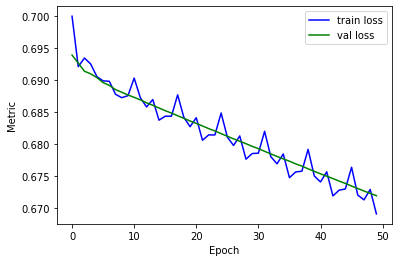

In [12]:
plot_metrics(train_loss, val_loss, 'train loss', 'val loss')

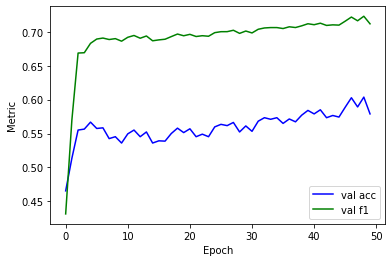

In [13]:
plot_metrics(val_acc, val_f1, 'val acc', 'val f1')

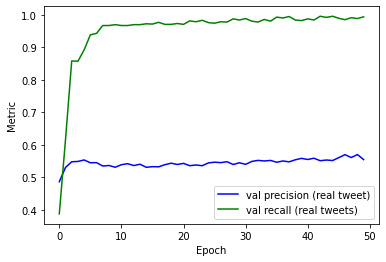

In [14]:
plot_metrics(val_prec, val_recall, 'val precision (real tweet)', 'val recall (real tweets)')

In [ ]:
len(val_labels)

2140

In [ ]:
sum(val_labels)

In [ ]:
sum(predicted)